In [ ]:
import pandas as pd
import os
import numpy as np
import math
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Bidirectional, Dropout, LSTM, TimeDistributed, Flatten, RepeatVector, BatchNormalization,Conv2D,GlobalAveragePooling2D,GlobalAveragePooling2D, LeakyReLU, AveragePooling2D,MaxPooling2D,SpatialDropout2D, Reshape, Lambda
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce


### The following files are required for training the Siamese Network. Please ensure they are in the same directory as this jupyter notebook. 



1.   'data_augmented.csv'
      
      This file contain keypoints data by video and frames. The data has been augmented from original file to increase its size. This is done with interpolation.

2.   'PersonLabel_augmented.csv'

      Each unique individual in the video is represented by a class label which is then one hot encoded. Person Label is the equivalent of class label. Original dataset has 44 classes representing 44 unique person. This file comprises of the one hot encoded labels. 



In [ ]:
# Connect to your Google Drive here
#
from google.colab import drive
drive.mount('/content/drive')


# Set the folder to point to where you downloaded the ESC dataset,
# and also the folder to point to where you intend to save the processed data
#
user_folder = '/content/drive/My Drive/ColabNotebooks/ITI110'

Mounted at /content/drive


### Define The Max Frame Size And Upload Data

In [ ]:
#max_frames is an important parameter to set. It defines the number of frames to capture and use for training the model in a video. 
# this parameter is also required when loading the trained model during live cam inference, onboarding or recorded video inference.
max_frame=95

pd.set_option('display.max_rows',None)


#df=pd.read_csv('data_normalized.csv')

df=pd.read_csv(user_folder+'/'+'data_augmented.csv')

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94
0,"[0.0, 0.0, 0.0, 0.0, 0.0002448784087915845, 0....","[0.17522129060731412, 0.2874729202431497, 0.0,...","[0.275779359207068, 0.26508140219964754, 0.0, ...","[0.2387925360778001, 0.3069714788637996, 0.0, ...","[0.20456744185837544, 0.30737914614479034, 0.0...","[0.24075421008753317, 0.35584099533804675, 0.0...","[0.25804888554524974, 0.31737329156146776, 0.0...","[0.17495590964359647, 0.2840891447979197, 0.0,...","[0.18076530371415564, 0.2767317541279658, 0.0,...","[0.20757447598040882, 0.28529764968514537, 0.0...","[0.2091182091145263, 0.30232406318830424, 0.0,...","[0.20010743464535025, 0.3298441852673377, 0.0,...","[0.21003737353317106, 0.3333837528591532, 0.0,...","[0.18854283561937127, 0.3064399035053147, 0.0,...","[0.1976422390846095, 0.34858295097922326, 0.0,...","[0.19934305760031792, 0.3278063230091262, 0.0,...","[0.19902218989551468, 0.3322032603021786, 0.0,...","[0.20018250715711758, 0.34316353455236803, 0.0...","[0.26038127720284104, 0.4232156687114082, 0.0,...","[0.27374810853647796, 0.3448762064162408, 0.0,...","[0.24733388351782823, 0.35316343893021707, 0.0...","[0.26387366023831255, 0.3669857277028243, 0.0,...","[0.2776930081004963, 0.33324635588744056, 0.0,...","[0.2492370334608279, 0.2941678728030825, 0.0, ...","[0.26911560583818733, 0.31380696604704733, 0.0...","[0.18519499920824312, 0.29302725548902425, 0.0...","[0.2354231687682618, 0.32608384131184087, 0.0,...","[0.2136604840336812, 0.3321463639378755, 0.0, ...","[0.2042403427475535, 0.3015386834501918, 0.0, ...","[0.22190930430560915, 0.2994399926689259, 0.0,...","[0.2464906595879739, 0.29182635343214014, 0.0,...","[0.2885980837410643, 0.2880883032159185, 0.0, ...","[50.926000000000045, 48.98800000000003, 0.0, 0...","[0.2627569603251295, 0.2632941308460845, 0.0, ...","[0.284142992599211, 0.24185011813109605, 0.0, ...","[0.24701302782674023, 0.32132327751772116, 0.0...","[0.24638835827805955, 0.28910689338446144, 0.0...","[0.30834423960710555, 0.28542341527901877, 0.0...","[0.26640699192961853, 0.28869674492562164, 0.0...","[0.26632188859231626, 0.27645178388849134, 0.0...",...,"[0.27970034949713257, 0.23506245698554942, 0.0...","[0.28919639688219234, 0.2465330947788163, 0.0,...","[0.28088683887841037, 0.23807794115973815, 0.0...","[0.25846902264532406, 0.25819463939410875, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.10381426449510446, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.09852515127200821, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.11071956599202543, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.09070648604143422, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.07684766337453774, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.04806560399794436, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.022558568811792093, -0....","[0.0, 0.0, 0.0, 0.0, 3.8899999999998727, -13.6...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 

In [ ]:
#df_label=pd.read_csv('PersonLabel.csv')
df_label=pd.read_csv(user_folder+'/'+'PersonLabel_augmented.csv')

df_label.head()

,PersonLabel
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
tf.__version__

'2.4.1'

In [ ]:
#this section here converts the 
import ast


def load_x(data):
   
    #print ("Processing " + infilepath)
    x = []
    
    for row in tqdm(data.itertuples(index=False)):

        # TODO:
        # Load each row from the CSV file and call the 
        # process_joints function.
        #...#
        x_row=[]
        for i in row:       
            #print(ast.literal_eval(i))
            x_row.append(ast.literal_eval(i))
        
        x.append(x_row)
    x = np.array(x)
    
    print(x.shape)
   # x = np.reshape(x,(x.shape(0), 60, 36)) #each video has 32 frames
    
    print ("Done.")
    return x

x=load_x(df)

792it [00:05, 149.96it/s]


(792, 95, 36)
Done.


### Crop the size of Frame required.

In [ ]:
#select on max_frame size.
x=x[:,:max_frame,:]
x.shape

(792, 95, 36)

In [ ]:
#personlabel='PersonLabel.csv'
personlabel=user_folder+'/'+'PersonLabel_augmented.csv'
import ast
def load_y(personlabel):
    df = pd.read_csv(personlabel)
    
    #print ("Processing " + personlabel)
    
    y = []
    index = 0
    for row in tqdm(df.itertuples(index=False)):
        for i in row:
          #print(ast.literal_eval(i))
          y.append(ast.literal_eval(i))
                    
    y = np.array(y)  
    return y

y=load_y(personlabel)
y.shape

792it [00:00, 17180.17it/s]


(792, 44)

For reference, here is the equation for the contrastive loss function that we’ll be implementing in Keras/TensorFlow code:

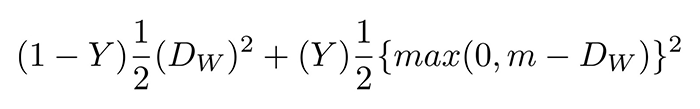

y: The ground-truth labels from our dataset. A value of 1 indicates that the two images in the pair are of the same class, while a value of 0 indicates that the images belong to two different classes.

preds: The predictions from our siamese network (i.e., distances between the image pairs).

margin: Margin used for the contrastive loss function (typically this value is set to 1).




In [ ]:
#This is the constrastive loss as defined above
def contrastive_loss(Y_true, D):
    margin = 1
    Y_true = tf.cast(Y_true, D.dtype)
    return K.mean(Y_true*K.square(D)+(1 - Y_true)*K.maximum((margin-D),0))

In [ ]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
from tensorflow.keras import backend as K

def cosine_distance(vectors):
    x, y = vectors
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

### Important Step To Make Pairs Of Input Data For Siamese Network

In [ ]:
def make_pairs_all(rowData, y_data):
    pair_rowData = []
    pairLabels = []
    pair_class_labels=[]
    
    labels=np.argmax(y_data, axis=1) #class labels in list arranged by their row positions
    #print('labels :',labels)
    #numClasses = len(np.unique(labels))
    #print(np.where(labels==12))
    #idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    idx = [np.where(labels == i)[0] for i in np.unique(labels,axis=0)] #row indices with same class labels
                                                                      #class label 0 are found in row 4,13,38
    #print('idx :',idx)
    #print([i for i in np.unique(labels,axis=0)])
#    print('Class label 12 found in row indices :',idx[0]) #0 represent its position in 'label' list.
#    print(np.where(labels != labels[0])) #labels[0]=labels[idxA], where idxA=0
#    print(np.where(labels != labels[0])[0])
    for idxA in tqdm(range(len(rowData))):
        
        sameClassLabel=None
        differentclassLabel1=None
        differentclassLabel2=None
        differentClass=None

        current_rowData = rowData[idxA]
        label = labels[idxA] #'label' is a set of row indices with same class label
        
        sameClassLabel=(label,label)
        print('sameClassLabel :',sameClassLabel)
        count=len(idx[label])
        for idxB in idx[label]:

        #idxB = np.random.choice(idx[label])  
          pos_rowData = rowData[idxB]
        
          pair_rowData.append([current_rowData, pos_rowData])
          pairLabels.append([1]) #same class will have '1' label
        
          pair_class_labels.append(sameClassLabel)

        
        #negIdx = np.where(labels != 12)[0] #negIdx are class labels that are not same as class represented by idxA.
        negIdx = np.where(labels != label)[0]
        #print('negIdx :',negIdx)
        negIdx= np.random.choice(negIdx,count)
        for a in negIdx:

        #a=np.random.choice(negIdx) #randomly choose a class not same as class represented by idxA.
          #print('Random Choice Of Row Indices Of Negative Class From Available List :',a)
          negLabelIdx=labels[a] #return index position of class label that matches to 'a'
          #print('negLabel use as index to select row indices with same class labels in idx: ',negLabelIdx)

          # differentclassLabel1=label
          # differentclassLabel2 =negLabelIdx
          # differentClass=(differentclassLabel1,differentclassLabel2)
          #print('differentClass :',differentClass)

          listNegLabel_indices=idx[negLabelIdx]
          #print('Row indices with same class label :',listNegLabel_indices)
          
          #for negIdxOfRow in listNegLabel_indices:
          negIdxOfRow=np.random.choice(listNegLabel_indices) #choose one row index from list comprising of same neg class.
          negData=rowData[negIdxOfRow]
        #negData=rowData[np.random.choice(np.random.choice(idx[negIdx])[0])]
        #negImage = rowData[np.random.choice(negIdx)]
            #print('negData :',negData)
          pair_rowData.append([current_rowData, negData])
          pairLabels.append([0]) # different class will be given '0' label

          pair_class_labels.append(differentClass)

    return (np.array(pair_rowData), np.array(pairLabels), pair_class_labels)

In [ ]:
#need to run these line of code when you change the max_frame size. 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify =y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(633, 95, 36) (159, 95, 36) (633, 44) (159, 44)


In [ ]:
X_train,X_val,y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify =y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(506, 95, 36) (127, 95, 36) (506, 44) (127, 44)


In [ ]:
pair_xtrain, pair_ytrain,classpair_xtrain=make_pairs_all(X_train,y_train)
pair_xtest, pair_ytest, classpair_xtest=make_pairs_all(X_test,y_test)

pair_xval, pair_yval,classpair_xval=make_pairs_all(X_val,y_val)


100%|██████████| 506/506 [00:00<00:00, 4726.34it/s]


sameClassLabel : (4, 4)
sameClassLabel : (18, 18)
sameClassLabel : (15, 15)
sameClassLabel : (41, 41)
sameClassLabel : (6, 6)
sameClassLabel : (26, 26)
sameClassLabel : (2, 2)
sameClassLabel : (28, 28)
sameClassLabel : (20, 20)
sameClassLabel : (42, 42)
sameClassLabel : (13, 13)
sameClassLabel : (18, 18)
sameClassLabel : (21, 21)
sameClassLabel : (5, 5)
sameClassLabel : (30, 30)
sameClassLabel : (31, 31)
sameClassLabel : (27, 27)
sameClassLabel : (22, 22)
sameClassLabel : (20, 20)
sameClassLabel : (21, 21)
sameClassLabel : (28, 28)
sameClassLabel : (19, 19)
sameClassLabel : (11, 11)
sameClassLabel : (4, 4)
sameClassLabel : (29, 29)
sameClassLabel : (3, 3)
sameClassLabel : (37, 37)
sameClassLabel : (23, 23)
sameClassLabel : (2, 2)
sameClassLabel : (8, 8)
sameClassLabel : (26, 26)
sameClassLabel : (41, 41)
sameClassLabel : (6, 6)
sameClassLabel : (38, 38)
sameClassLabel : (30, 30)
sameClassLabel : (2, 2)
sameClassLabel : (8, 8)
sameClassLabel : (0, 0)
sameClassLabel : (33, 33)
sameClassL

100%|██████████| 127/127 [00:00<00:00, 8334.01it/s]

sameClassLabel : (30, 30)
sameClassLabel : (0, 0)
sameClassLabel : (38, 38)
sameClassLabel : (15, 15)
sameClassLabel : (36, 36)
sameClassLabel : (43, 43)
sameClassLabel : (32, 32)
sameClassLabel : (38, 38)
sameClassLabel : (38, 38)
sameClassLabel : (32, 32)
sameClassLabel : (29, 29)
sameClassLabel : (35, 35)
sameClassLabel : (15, 15)
sameClassLabel : (0, 0)
sameClassLabel : (36, 36)
sameClassLabel : (24, 24)
sameClassLabel : (34, 34)
sameClassLabel : (29, 29)
sameClassLabel : (43, 43)
sameClassLabel : (23, 23)
sameClassLabel : (22, 22)
sameClassLabel : (25, 25)
sameClassLabel : (34, 34)
sameClassLabel : (23, 23)
sameClassLabel : (17, 17)
sameClassLabel : (25, 25)
sameClassLabel : (26, 26)
sameClassLabel : (10, 10)
sameClassLabel : (10, 10)
sameClassLabel : (15, 15)
sameClassLabel : (8, 8)
sameClassLabel : (22, 22)
sameClassLabel : (23, 23)
sameClassLabel : (2, 2)
sameClassLabel : (41, 41)
sameClassLabel : (37, 37)
sameClassLabel : (33, 33)
sameClassLabel : (21, 21)
sameClassLabel : (24

In [ ]:

print('pair_xtrain, pair_ytrain,classpair_xtrain', pair_xtrain.shape, pair_ytrain.shape,len(classpair_xtrain))
print('pair_xtest, pair_ytest, classpair_xtest', pair_xtest.shape, pair_ytest.shape, len(classpair_xtest))
print('pair_xval, pair_yval,classpair_xval',pair_xval.shape, pair_yval.shape,len(classpair_xval))

pair_xtrain, pair_ytrain,classpair_xtrain (11660, 2, 95, 36) (11660, 1) 11660
pair_xtest, pair_ytest, classpair_xtest (1170, 2, 95, 36) (1170, 1) 1170
pair_xval, pair_yval,classpair_xval (742, 2, 95, 36) (742, 1) 742


In [ ]:
# pair_xtrain, pair_ytrain,classpair_xtrain=make_pairs(X_train,y_train)
# pair_xtest, pair_ytest, classpair_xtest=make_pairs(X_test,y_test)

# pair_xval, pair_yval,classpair_xval=make_pairs(X_val,y_val)

In [ ]:
# print(pair_xtrain.shape, pair_ytrain.shape)

(1012, 2, 20, 36) (1012, 1)


In [ ]:
# print(pair_ytrain)

[[1]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


In [ ]:
# print((pair_xtrain[0]))

### Siamese Model Definition

In [ ]:
l2_rate=0.01
input_shape=(max_frame,36)
#input_shape=(95,36)


from tensorflow.keras.layers import Subtract, Multiply,Concatenate
from tensorflow.keras.layers import LeakyReLU, LayerNormalization
from keras.utils.vis_utils import plot_model


def build_siamese_model(input_shape):

  input1 = Input(shape=input_shape)
  input2 = Input(shape=input_shape)
    
  #model = Sequential()
  model2=Sequential([
                  Bidirectional(LSTM(32,return_sequences=True, kernel_regularizer=l2(l2_rate),input_shape=input_shape)),
                  LeakyReLU(alpha=0.3),
                  BatchNormalization(),
                  TimeDistributed(Dense(32)),
                  # Bidirectional(LSTM(32,return_sequences=True,kernel_regularizer=l2(l2_rate)),merge_mode='mul'),
                  # LeakyReLU(alpha=0.3),
                  # BatchNormalization(renorm=True),
                  # TimeDistributed(Flatten()),
                  # Dropout(0.3),
                  # Dense(32,kernel_regularizer=regularizers.l1_l2(l1=0.1,l2=0.1)),
                  # LeakyReLU(alpha=0.3),
                  # BatchNormalization(),
                  #Dropout(0.3),
                  Flatten(),
                  Dense(64, activation='relu'),
                  BatchNormalization(),
                  Dropout(0.1),
                  Dense(64)
                  #Dense(128),
                  #LeakyReLU(alpha=0.3)
                  ]) 
  encoded_l=model1(input1)
  #encoded_l=TimeDistributed(Dense(64))(encoded_l)
  #encoded_l=Bidirectional(LSTM(128,return_sequences=False,kernel_regularizer=l2(l2_rate)),merge_mode='concat')(encoded_l)

  encoded_r=model1(input2)
  #encoded_r=TimeDistributed(Dense(64))(encoded_r)
  #encoded_r=Bidirectional(LSTM(128,return_sequences=False,kernel_regularizer=l2(l2_rate)),merge_mode='concat')(encoded_r)


  # print(encoded_l.shape,encoded_r.shape) 
  
  subtracted = Subtract()([encoded_l, encoded_r])
  x3=Multiply()([subtracted,subtracted])
  x1=Multiply()([encoded_l,encoded_l])
  x2=Multiply()([encoded_r,encoded_r])
  x4=Subtract()([x1,x2])
  
  x5=Lambda(cosine_distance,output_shape=cos_dist_output_shape )([encoded_l, encoded_r])
  # # conc = Concatenate(axis=-1)([x5,x4, x3])

  # # x = Dense(64, activation="elu", name='conc_layer',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.05))(conc)
  # #print('x5',x5.shape,'x4',x4.shape,'x3',x3.shape, 'conc',conc.shape)
  # # x=BatchNormalization()(x)
  # # x = Dropout(0.3)(x)
  # # x = Dense(64, activation="elu", name='conc_layer',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.05))(x)
  # # x=BatchNormalization()(x)
  # # x = Dropout(0.3)(x)
  # # x = Dense(64, activation="elu",kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.05))(x)
  # # x=BatchNormalization()(x)
  # # x = Dropout(0.3)(x)
  L1_layer = Lambda(euclidean_distance, output_shape=(1,))([encoded_l, encoded_r])
  conc = Concatenate(axis=-1)([x5,x4, x3,L1_layer])
  x = Dense(16, activation="elu", name='conc_layer',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.01))(conc)
  x=BatchNormalization()(x)
  x = Dropout(0.3)(x)
  prediction=Dense(1, activation="sigmoid",name = 'out')(x)

  #L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  #prediction  = L1_layer([encoded_l, encoded_r])
  

  # x = Dense(64, activation="elu", name='conc_layer',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.05))(L1_distance)
  # x=BatchNormalization()(x)
  # x = Dropout(0.3)(x)
  # #prediction = Dense(1, activation="elu", name = 'out')(L1_distance)
  # prediction = Dense(1,activation='sigmoid', name = 'out')(x)



  # distance =Lambda(euclidean_distance)([encoded_l,encoded_r])
  # #distance=Dense(1, activation="sigmoid")(distance)
  # conc = Concatenate(axis=-1)([x5,distance,x4,x3,subtracted])

  # print('conc', conc.shape, 'distance',distance.shape, 'subtracted', subtracted.shape)
  # x=LayerNormalization()(conc)
  # x = Dense(512, activation="elu", name='conc_layer',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.15))(conc)
  # #x=BatchNormalization()(x)
  # x = Dropout(0.3)(x)
  # #prediction = Dense(1, activation="sigmoid", name = 'out')(x)
  # prediction = Dense(1, activation="elu", name = 'out')(x)

  
#In simple words, the two images are featurized using a common network, 
#then these two feature vectors can be directly used or sent through some decision making network to check for similarity between images.

  #prediction = Dense(1, activation='sigmoid')(subtracted)
  siamese_net = Model([input1, input2],prediction)

  optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False) 
  siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
  #siamese_net.compile(loss=contrastive_loss, optimizer=optimizer)
  
  return siamese_net

model=build_siamese_model(input_shape)

  
training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = user_folder+'/train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/model.{epoch:04d}-loss-{val_loss:4.2f}.h5',
        monitor='val_acc', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True)
]
model.layers[2].summary()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

history = model.fit(
    [pair_xtrain[:, 0], pair_xtrain[:, 1]], pair_ytrain[:],
    validation_data=([pair_xval[:, 0], pair_xval[:, 1]], pair_yval[:]),
    batch_size=200,
    verbose=1,
    callbacks=callbacks_list,
    shuffle=True,
    epochs=100)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 95, 64)            17664     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 95, 64)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 95, 64)            256       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 95, 32)            2080      
_________________________________________________________________
flatten_3 (Flatten)          (None, 3040)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                194624    
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)               

In [ ]:
model.save(user_folder+'/'+'siamesenetwork.h5')

In [ ]:
history

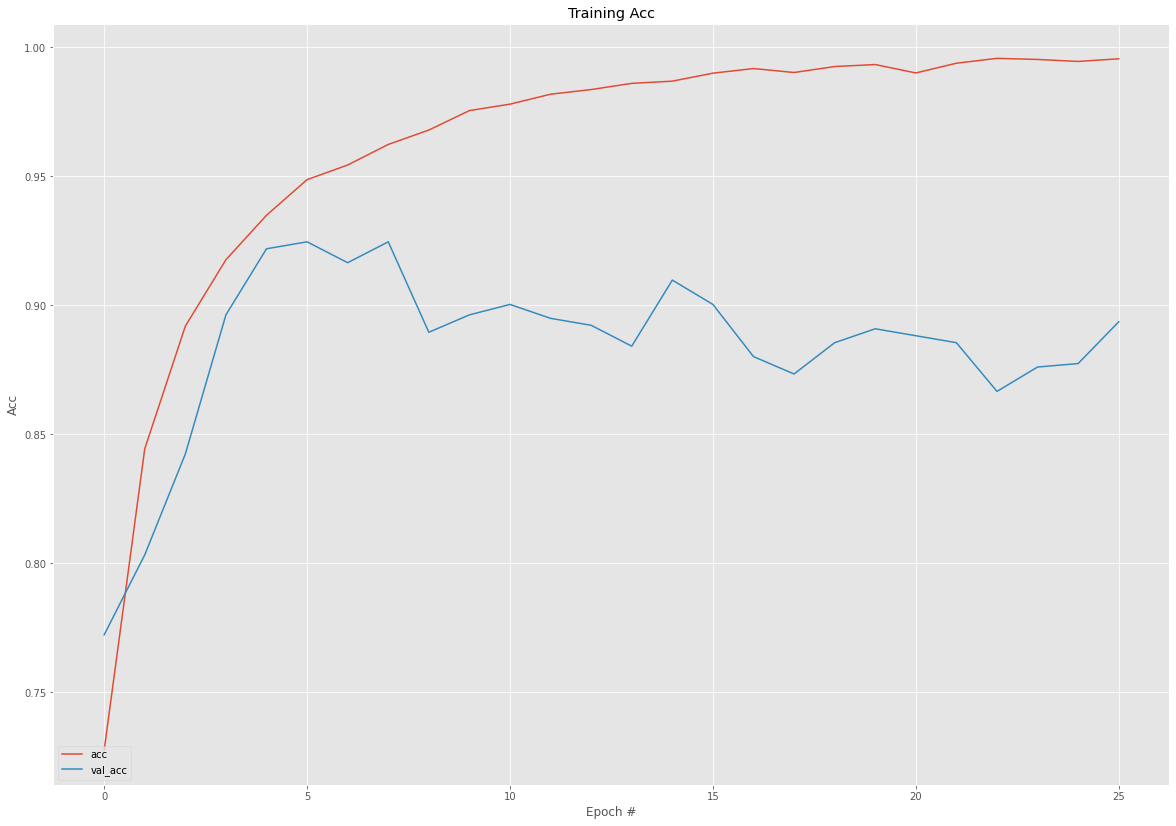

In [ ]:
def plot_training(h): #plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure(figsize=(20,14))
    plt.plot(h.history["acc"][:], label="acc") #plot from the 10th epoch onwards. Avoid plotting early epoch's large values.
    plt.plot(h.history["val_acc"][:], label="val_acc")
    plt.title("Training Acc")
    plt.xlabel("Epoch #")
    plt.ylabel("Acc")
    plt.legend(loc="lower left")
plot_training(history)

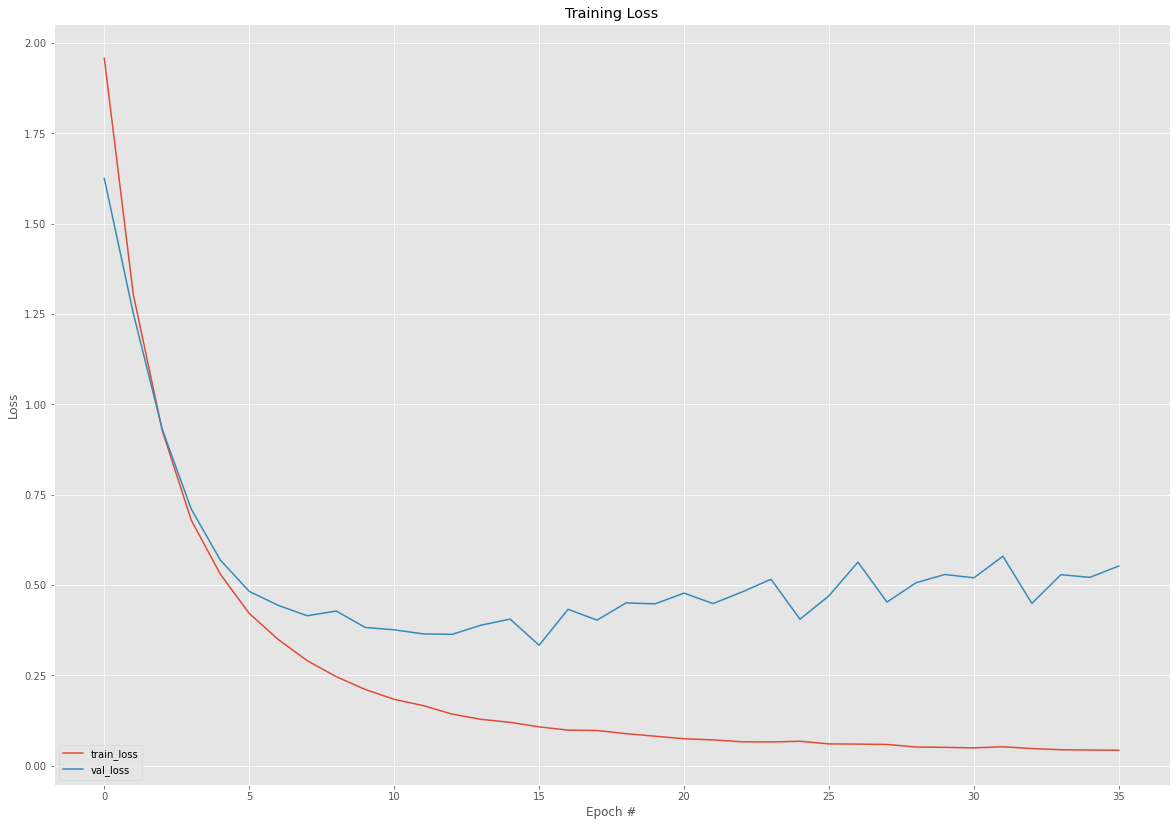

In [ ]:
def plot_training(h): #plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure(figsize=(20,14))
    plt.plot(h.history["loss"][:], label="train_loss") #plot from the 10th epoch onwards. Avoid plotting early epoch's large values.
    plt.plot(h.history["val_loss"][:], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
plot_training(history)

In [ ]:
from tensorflow.keras.models import load_model

#model.load_weights(user_folder+'/'+'siamesenetwork.h5')

In [ ]:
model.save(user_folder+'/'+'siamesenetwork.h5')

### Confusion Matrix

In [ ]:
threshold=0.5
# [1 if i>threshold else 0 for i in predict_train] 

  0%|          | 0/1170 [00:00<?, ?it/s]

(1170, 2, 95, 36)


100%|██████████| 1170/1170 [01:00<00:00, 19.20it/s]



 Confusion Matrix For Train Data 
 [[542  32]
 [  2 594]]
(1170,) (1170,)

 Confusion Matrix For Test Data 
 [[505  80]
 [ 60 525]]
Train Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       574
           1       0.95      1.00      0.97       596

    accuracy                           0.97      1170
   macro avg       0.97      0.97      0.97      1170
weighted avg       0.97      0.97      0.97      1170


Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       585
           1       0.87      0.90      0.88       585

    accuracy                           0.88      1170
   macro avg       0.88      0.88      0.88      1170
weighted avg       0.88      0.88      0.88      1170



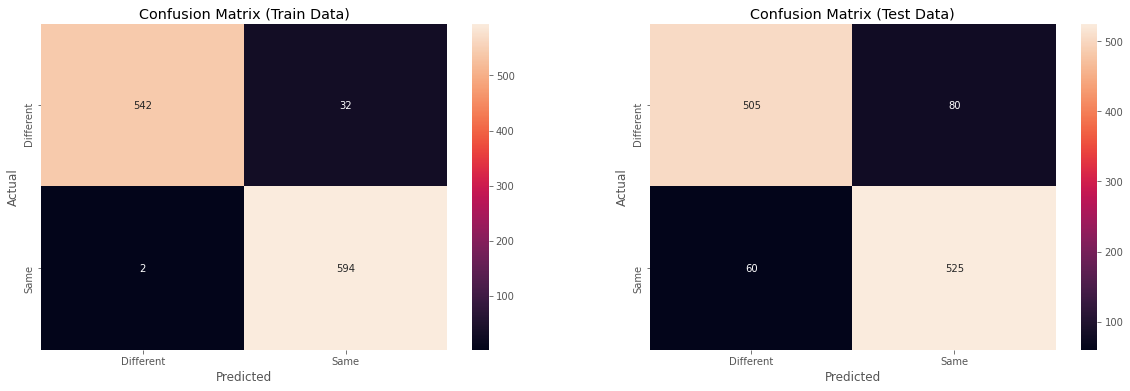

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
labels=np.unique(y, axis=0)

def prediction(model,data):
  predictedResult=[]
  for eachrow in tqdm(data):
    #print(eachrow.shape)
    #print(eachrow[0].shape)
    input1=eachrow[0].reshape((1,max_frame,36))
    input2=eachrow[1].reshape((1,max_frame,36))
    #print(a.shape)
    result=model.predict([input1,input2])
    predictedResult.append(result.item())
  return predictedResult

threshold=0.5
size=1170  #same size as x_test set

def classifyprediction(predictResult, threshold):
    return [1 if i>threshold else 0 for i in predictResult] 


def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):
    
    '''
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    '''
    #randomly select pairs
    #select index
    np.random.seed(seed=42)
    x_train_index=np.random.choice(range(0,len(pair_xtrain)), size=size)
    x_train=x_train[x_train_index]
    y_train=y_train[x_train_index]

    pred_y_train = []
    pred_y_test = []

    print (x_train.shape)
    
    pred_y_train = prediction(keras_model,x_train)
    pred_y_train=classifyprediction(pred_y_train, threshold)
    pred_y_train = np.array(pred_y_train)


    x_train = np.array(x_train)

    y_train=[i.item() for i in y_train]
    y_train = np.array(y_train)
    

    pred_y_test = prediction(keras_model,x_test)
    pred_y_test=classifyprediction(pred_y_test, threshold)
    pred_y_test=np.array(pred_y_test)

    x_test = np.array(x_test)
    
    y_test=[i.item() for i in y_test]
    y_test = np.array(y_test)


    #test_generator.on_epoch_end()

    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    #
    # y_train_index = y_train
    # pred_y_train_index = pred_y_train
    # y_test_index = y_test
    # pred_y_test_index = pred_y_test

    # y_train_index = y_train.argmax(axis=1)
    # pred_y_train_index = pred_y_train.argmax(axis=1)
    # y_test_index = y_test.argmax(axis=1)
    # pred_y_test_index = pred_y_test.argmax(axis=1)
    
    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train, pred_y_train)
    print('\n','Confusion Matrix For Train Data','\n',cm)
    labels=['Different','Same']
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True,fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')  

    # cm_df = pd.DataFrame(cm, labels, labels)          
    # plt.subplot(1, 2, 1)
    # plt.title('Confusion Matrix (Train Data)')
    # sns.heatmap(cm_df, annot=True)
    # plt.ylabel('Actual')
    # plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    print(y_test.shape,pred_y_test.shape)
    cm = confusion_matrix(y_test, pred_y_test)
    print('\n','Confusion Matrix For Test Data','\n',cm)
    labels=['Different','Same']
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True,fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')  

    # cm_df = pd.DataFrame(cm, labels, labels)          
    # plt.subplot(1, 2, 2)
    # plt.title('Confusion Matrix (Test Data)')
    # sns.heatmap(cm_df, annot=True)
    # plt.ylabel('Actual')
    # plt.xlabel('Predicted')        
    
    #plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(y_train, pred_y_train ))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(y_test, pred_y_test))
    

# Exclude the O tags from the confusion matrix.
#
display_classification_confusion_matrix(model, pair_xtrain, pair_ytrain, pair_xtest, pair_ytest, labels)